In [2]:
%load_ext autoreload
%autoreload 2
from src.model import OrderBooksDataSequenceDatasetV1, S3OrderBookDataSource

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
filepath = "output/output/2019-10-27-1572188645-1572209244.tar.gz" 
import boto3 
s3_client = boto3.client("s3")
source = S3OrderBookDataSource(
    bucket_name="btc-order-book",
    s3_client=s3_client
)

In [41]:
from numpy.testing import assert_almost_equal


import pickle 
import pandas as pd 
import numpy as np

from numpy.testing import assert_almost_equal


import pickle 
import pandas as pd 
import numpy as np

PRICE_DIFF_BEST_BINS = pickle.load(open("data/price_diff_best_bins_256_003_handcrafted_including_negative.bin", "rb"))
AMOUNT_BEST_BINS = pickle.load(open("data/amount_usd_best_bins_256_003.bin", "rb"))
AMOUNT_INDICES = dict(zip(AMOUNT_BEST_BINS, list(range(len(AMOUNT_BEST_BINS)))))
PRICE_DIFF_INDICES = dict(zip(PRICE_DIFF_BEST_BINS, list(range(len(PRICE_DIFF_BEST_BINS)))))


def get_future_time_ob(order_books, seconds, i):
    o = max([o for o in order_books if o.timestamp >= order_books[i].timestamp and o.timestamp <= order_books[i].timestamp + seconds ], key=lambda o : o.timestamp)
    if o.s3_key == order_books[-1].s3_key:
        return None     
    return o

def verify_x(order_books, i, x):
    accepted_bids = [b for b in order_books[i].bids if (b.price >= order_books[i].current_price * 0.97)]    
    accepted_ask = [b for b in order_books[i].asks if (b.price / order_books[i].current_price - 1 <=  0.03)]
    
    x_ind = pd.cut([(a.amount  * order_books[i].current_price) for a in accepted_ask], AMOUNT_BEST_BINS)
    y_ind = pd.cut([(a.price / order_books[i].current_price - 1) for a in accepted_ask], PRICE_DIFF_BEST_BINS)


    m_asks = np.zeros((len(AMOUNT_BEST_BINS), len(PRICE_DIFF_BEST_BINS)))

    for x_,y_ in zip(x_ind, y_ind):
        idx_x = AMOUNT_INDICES[x_]
        idx_y = PRICE_DIFF_INDICES[y_]

        m_asks[idx_x, idx_y] += 1
        
    assert np.sum(np.abs(x['asks_sparse'].toarray() - m_asks)) < 2
    
    
    x_ind = pd.cut([(a.amount  * order_books[i].current_price) for a in accepted_bids], AMOUNT_BEST_BINS)
    y_ind = pd.cut([(1 - (a.price / order_books[i].current_price)) for a in accepted_bids], PRICE_DIFF_BEST_BINS)


    m_bids = np.zeros((len(AMOUNT_BEST_BINS), len(PRICE_DIFF_BEST_BINS)))

    for x_,y_ in zip(x_ind, y_ind):
        idx_x = AMOUNT_INDICES[x_]
        idx_y = PRICE_DIFF_INDICES[y_]

        m_bids[idx_x, idx_y] += 1
    
    
    assert np.sum(np.abs(x['bids_sparse'].toarray() - m_bids)) < 2


def verify_y(order_books, i, y):

    current_price = order_books[i].current_price 
    price_in_max_30s = (current_price * y[0, i]) if y[0, i] is not None else None 
    price_in_max_60s = (current_price * y[1, i])  if y[1, i] is not None else None 
    price_in_max_120s =  (current_price * y[2, i]) if y[2, i] is not None else None 
    price_in_max_300s = (current_price *  y[3, i]) if y[3, i] is not None else None 
    price_in_max_600s =  (current_price * y[4, i]) if y[4, i] is not None else None 
    price_in_max_1200s =  (current_price * y[5, i]) if y[5, i] is not None else None 
    price_in_max_3600s =  (current_price * y[6, i]) if y[6, i] is not None else None 

    o_30 = get_future_time_ob(order_books, 30, i)
    o_60 = get_future_time_ob(order_books, 60, i)
    o_120 = get_future_time_ob(order_books, 120, i)
    o_300 = get_future_time_ob(order_books, 300, i)
    o_600 = get_future_time_ob(order_books, 600, i)
    o_1200 = get_future_time_ob(order_books, 1200, i)
    o_3600 = get_future_time_ob(order_books, 3600, i)
    
    if o_30 is None:
        assert price_in_max_30s is None 
    else:
        assert_almost_equal(o_30.current_price,price_in_max_30s)

    if o_60 is None:
        assert price_in_max_60s is None 
    else:
        assert_almost_equal(o_60.current_price,price_in_max_60s)

    if o_120 is None:
        assert price_in_max_120s is None 
    else:
        assert_almost_equal(o_120.current_price,price_in_max_120s)

    if o_300 is None:
        assert price_in_max_300s is None 
    else:
        assert_almost_equal(o_300.current_price,price_in_max_300s)

    if o_600 is None:
        assert price_in_max_600s is None 
    else:
        assert_almost_equal(o_600.current_price,price_in_max_600s)

    if o_1200 is None:
        assert price_in_max_1200s is None 
    else:
        assert_almost_equal(o_1200.current_price,price_in_max_1200s)

    if o_3600 is None:
        assert price_in_max_3600s is None 
    else:
        assert_almost_equal(o_3600.current_price,price_in_max_3600s)

def verify_file(filepath):
    members = OrderBooksDataSequenceDatasetV1.load(filepath)
    x,y, idx, metadata = members
    assert int(idx[0][11:]) == int(metadata['first_timestamp'])
    assert int(idx[-1][11:]) == int(metadata['last_timestamp'])
    order_books = source.get_all_order_books(idx)
    for i in range(len(order_books)):
        verify_y(order_books,i, y)
        verify_x(order_books, i, x[i])
        








        


def get_future_time_ob(order_books, seconds, i):
    o = max([o for o in order_books if o.timestamp >= order_books[i].timestamp and o.timestamp <= order_books[i].timestamp + seconds ], key=lambda o : o.timestamp)
    if o.s3_key == order_books[-1].s3_key:
        return None     
    return o

def verify_x(order_books, i, x):
    accepted_bids = [b for b in order_books[i].bids if (b.price >= order_books[i].current_price * 0.97)]    
    accepted_ask = [b for b in order_books[i].asks if (b.price / order_books[i].current_price - 1 <=  0.03)]
    
    x_ind = pd.cut([(a.amount  * order_books[i].current_price) for a in accepted_ask], AMOUNT_BEST_BINS)
    y_ind = pd.cut([(a.price / order_books[i].current_price - 1) for a in accepted_ask], PRICE_DIFF_BEST_BINS)


    m_asks = np.zeros((len(AMOUNT_BEST_BINS), len(PRICE_DIFF_BEST_BINS)))

    for x_,y_ in zip(x_ind, y_ind):
        idx_x = AMOUNT_INDICES[x_]
        idx_y = PRICE_DIFF_INDICES[y_]

        m_asks[idx_x, idx_y] += 1
    
    m_asks_from_file = np.zeros(shape=(256, 256))        
    m_asks_from_file[x['asks_sparse'][i][0], x['asks_sparse'][i][1]] = x['asks_sparse'][i][2]


    assert np.sum(np.abs(m_asks_from_file - m_asks)) < 2
    
    
    x_ind = pd.cut([(a.amount  * order_books[i].current_price) for a in accepted_bids], AMOUNT_BEST_BINS)
    y_ind = pd.cut([(1 - (a.price / order_books[i].current_price)) for a in accepted_bids], PRICE_DIFF_BEST_BINS)


    m_bids = np.zeros((len(AMOUNT_BEST_BINS), len(PRICE_DIFF_BEST_BINS)))
    m_bids_from_file = np.zeros(shape=(256, 256))
    m_bids_from_file[x['bids_sparse'][i][0], x['bids_sparse'][i][1]] = x['bids_sparse'][i][2]
    
    
    for x_,y_ in zip(x_ind, y_ind):
        idx_x = AMOUNT_INDICES[x_]
        idx_y = PRICE_DIFF_INDICES[y_]

        m_bids[idx_x, idx_y] += 1
    
    
    assert np.sum(np.abs(m_bids_from_file  - m_bids)) < 2


def verify_y(order_books, i, y):

    current_price = order_books[i].current_price 
    price_in_max_30s = (current_price * y[0, i]) if y[0, i] is not None else None 
    price_in_max_60s = (current_price * y[1, i])  if y[1, i] is not None else None 
    price_in_max_120s =  (current_price * y[2, i]) if y[2, i] is not None else None 
    price_in_max_300s = (current_price *  y[3, i]) if y[3, i] is not None else None 
    price_in_max_600s =  (current_price * y[4, i]) if y[4, i] is not None else None 
    price_in_max_1200s =  (current_price * y[5, i]) if y[5, i] is not None else None 
    price_in_max_3600s =  (current_price * y[6, i]) if y[6, i] is not None else None 

    o_30 = get_future_time_ob(order_books, 30, i)
    o_60 = get_future_time_ob(order_books, 60, i)
    o_120 = get_future_time_ob(order_books, 120, i)
    o_300 = get_future_time_ob(order_books, 300, i)
    o_600 = get_future_time_ob(order_books, 600, i)
    o_1200 = get_future_time_ob(order_books, 1200, i)
    o_3600 = get_future_time_ob(order_books, 3600, i)
    
    if o_30 is None:
        assert price_in_max_30s is None 
    else:
        assert_almost_equal(o_30.current_price,price_in_max_30s)

    if o_60 is None:
        assert price_in_max_60s is None 
    else:
        assert_almost_equal(o_60.current_price,price_in_max_60s)

    if o_120 is None:
        assert price_in_max_120s is None 
    else:
        assert_almost_equal(o_120.current_price,price_in_max_120s)

    if o_300 is None:
        assert price_in_max_300s is None 
    else:
        assert_almost_equal(o_300.current_price,price_in_max_300s)

    if o_600 is None:
        assert price_in_max_600s is None 
    else:
        assert_almost_equal(o_600.current_price,price_in_max_600s)

    if o_1200 is None:
        assert price_in_max_1200s is None 
    else:
        assert_almost_equal(o_1200.current_price,price_in_max_1200s)

    if o_3600 is None:
        assert price_in_max_3600s is None 
    else:
        assert_almost_equal(o_3600.current_price,price_in_max_3600s)

def verify_file(filepath):
    members = OrderBooksDataSequenceDatasetV1.load(filepath)
    x,y, idx, metadata = members
    assert int(idx[0][11:]) == int(metadata['first_timestamp'])
    assert int(idx[-1][11:]) == int(metadata['last_timestamp'])
    order_books = source.get_all_order_books(idx)
    for i in range(len(order_books)):
        verify_y(order_books,i, y)
        verify_x(order_books, i, x)
        








        

In [ ]:
import os
import random 
for f in os.listdir("output/"):
    filepath = "output/" + f   
    verify_file(filepath)
    print(filepath)


output/2020-09-25-1601040027-1601060571.tar.gz
output/2020-07-03-1593807022-1593827535.tar.gz
output/2021-05-21-1621632024-1621652693.tar.gz
output/2020-07-08-1594212023-1594232598.tar.gz
output/2020-03-20-1584730916-1584751958.tar.gz
output/2021-10-22-1634875824-1634896555.tar.gz
output/2020-10-20-1603233061-1603253548.tar.gz
output/2021-02-26-1614303801-1614324536.tar.gz
output/2020-09-07-1599466228-1599486735.tar.gz
output/2020-11-18-1605705528-1605726165.tar.gz
output/2020-09-17-1600344624-1600365183.tar.gz


In [24]:
m_asks = np.zeros((len(AMOUNT_BEST_BINS), len(PRICE_DIFF_BEST_BINS)))

for x_,y_ in zip(x_ind, y_ind):
    idx_x = AMOUNT_INDICES[x_]
    idx_y = PRICE_DIFF_INDICES[y_]

    m_asks[idx_x, idx_y] += 1

m_asks_from_file = np.zeros(shape=(256, 256))
m_asks_from_file[x['asks_sparse'][i][0], x['asks_sparse'][i][1]] = x['asks_sparse'][i][2]



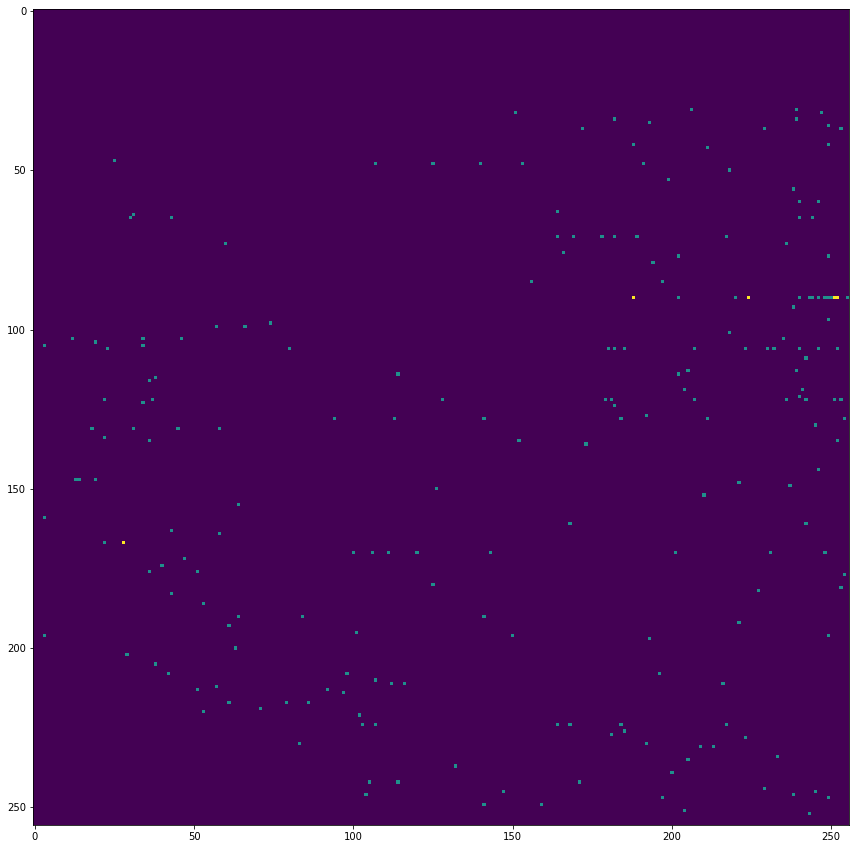

In [30]:
plt.figure(figsize=(20,15))
plt.imshow(m_asks_from_file)

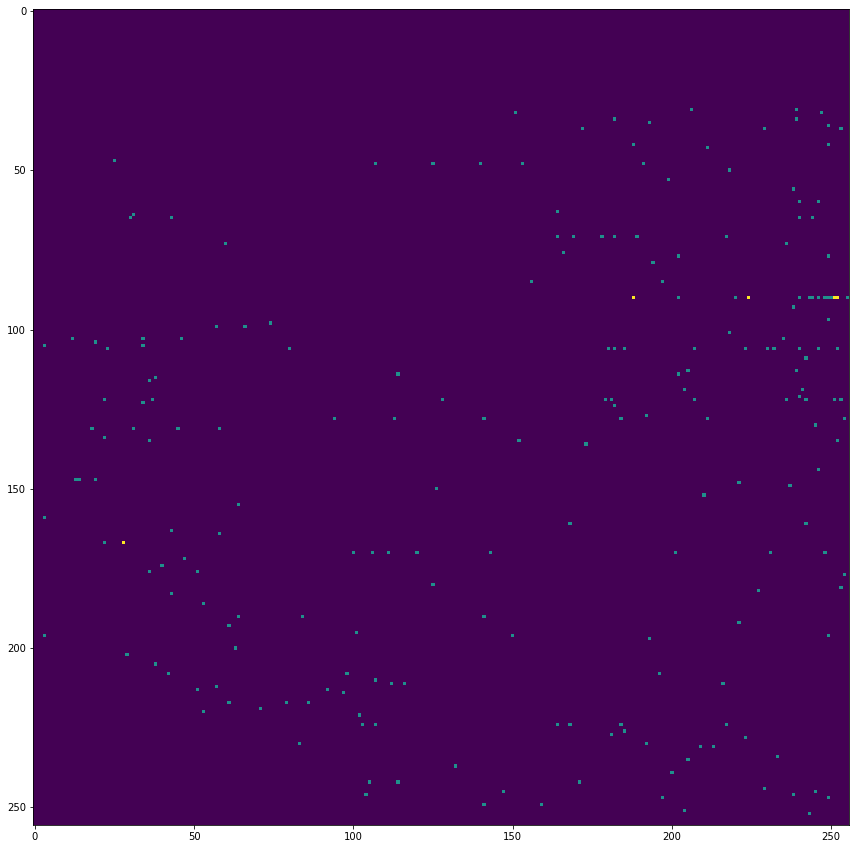

In [31]:
plt.figure(figsize=(20,15))
plt.imshow(m_asks)